In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

df = pd.read_csv('A3/train.csv', index_col='ArticleId')
X_train = df['Text']
df['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_train = df['Category']

df_test = pd.read_csv('A3/test.csv', index_col='ArticleId')
X_test = df_test['Text']
df_test['Category'].replace(['tech', 'entertainment'], [0,1], inplace=True)
Y_test = df_test['Category']

temp_complete_test = pd.concat([X_train, X_test])

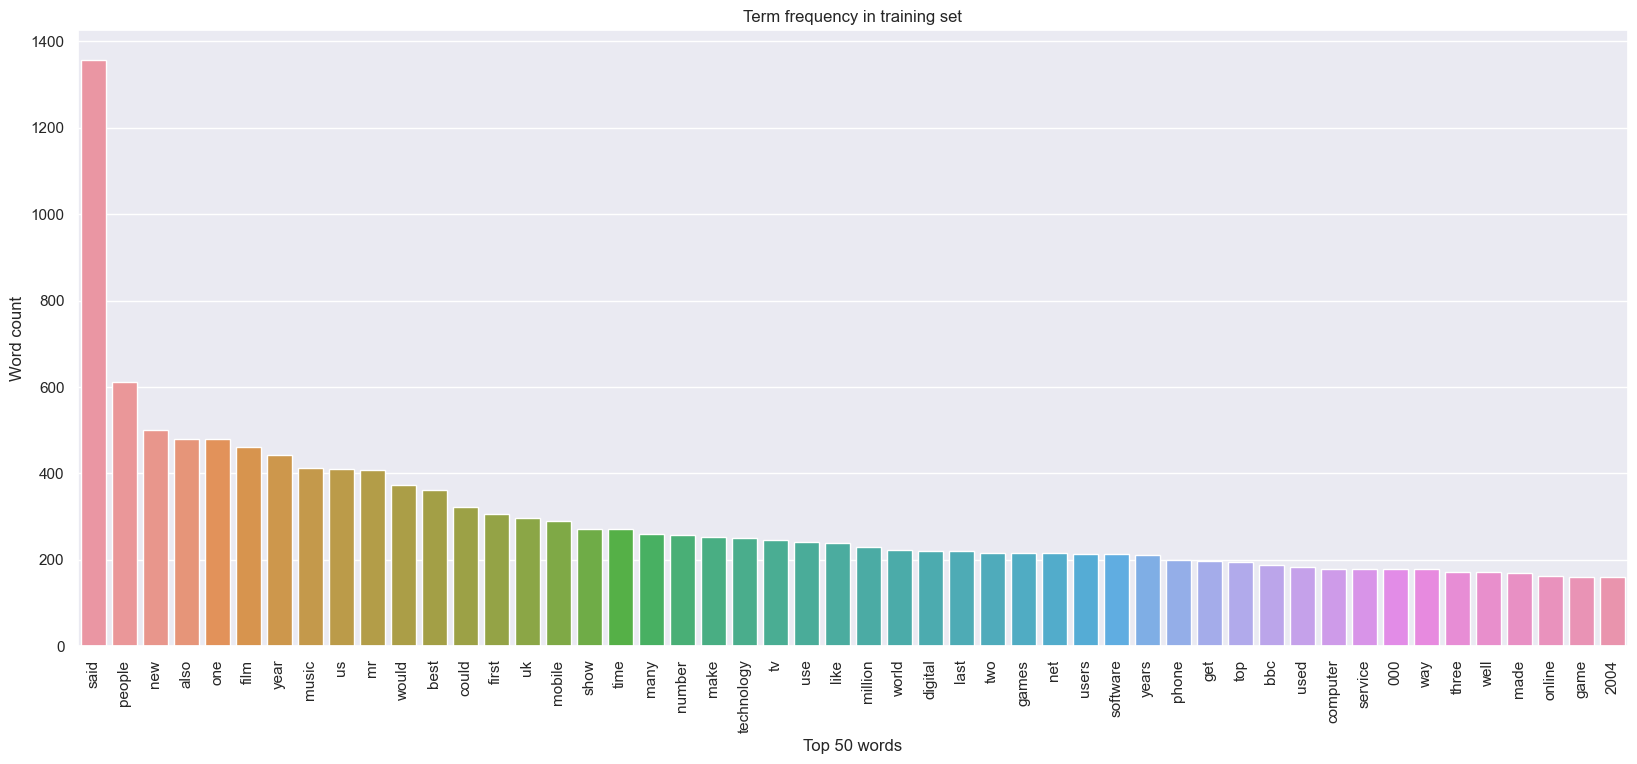

In [2]:
# Frequency count for dataset
vectorizer = CountVectorizer()
vectorizer.fit(temp_complete_test)
# Encode document
vector = vectorizer.transform(temp_complete_test)
prep_X_count = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=temp_complete_test.index)

prep_X_train_count = prep_X_count[:428]
prep_X_test_count = prep_X_count[428:]

train_sum = prep_X_train_count.sum().sort_values(ascending=False)
test_sum = prep_X_test_count.sum().sort_values(ascending=False)

train_top_50 = train_sum.head(50)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(20,8)})
plot = sns.barplot(x=train_top_50.index, y=train_top_50.values)
plot.set_xlabel('Top 50 words')
plot.set_ylabel('Word count')
plot.set_title('Term frequency in training set')
plt.xticks(rotation = 90)
plt.show()

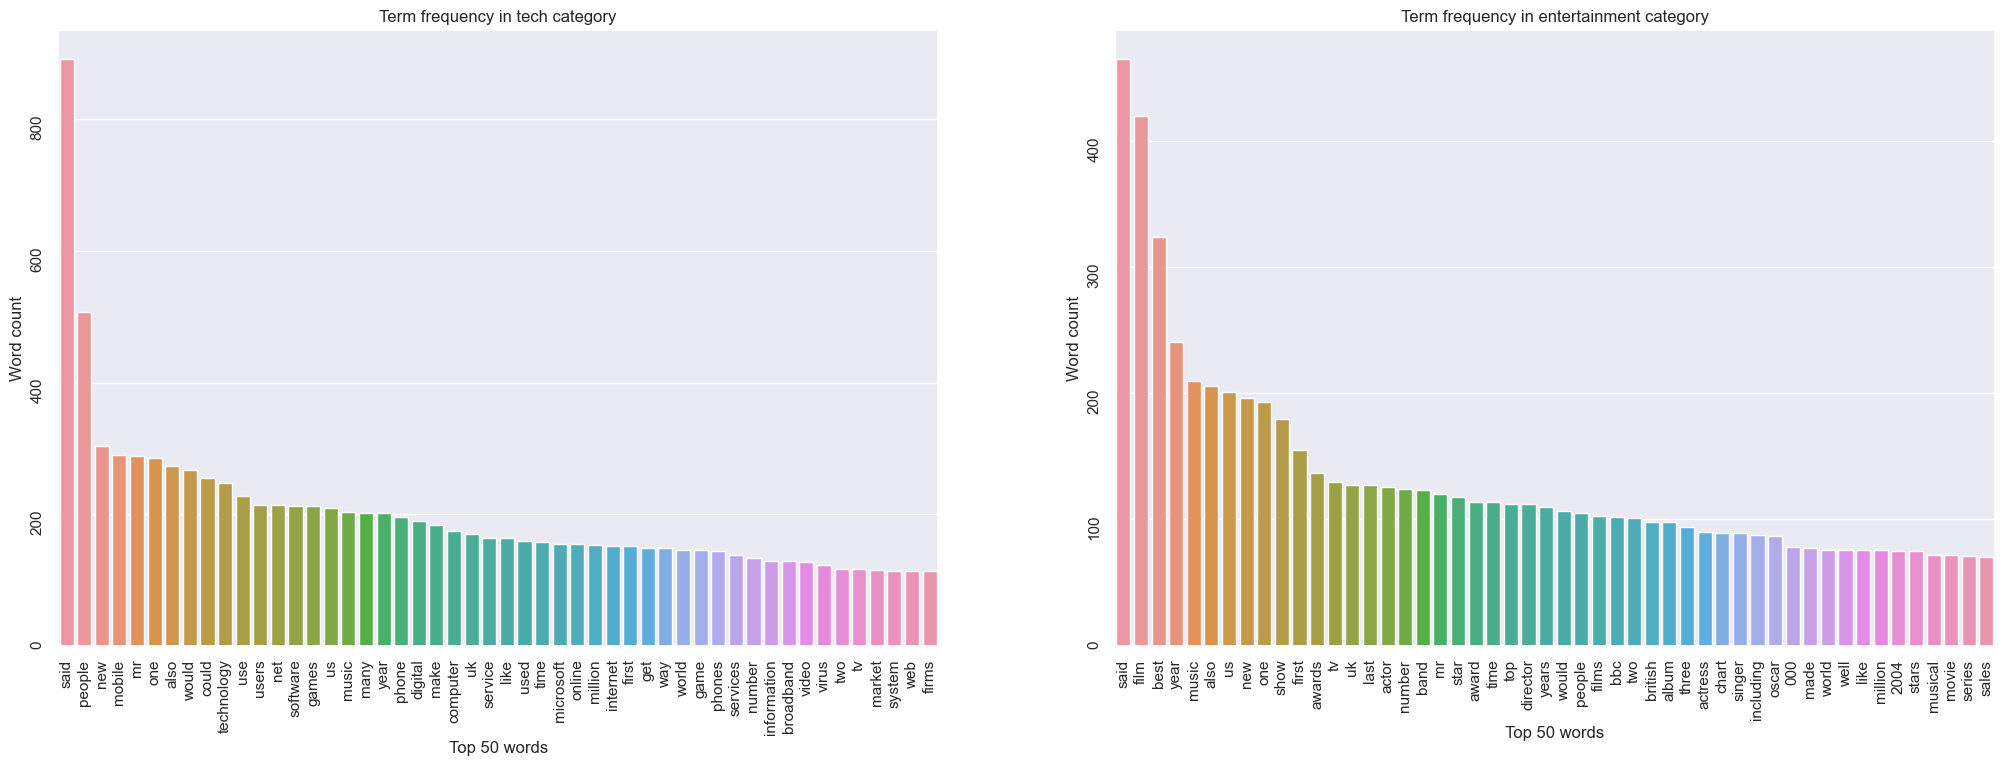

In [3]:
train_label_group = Y_train.groupby(Y_train)
train_tech, train_entertain = train_label_group.get_group(0).index, train_label_group.get_group(1).index

train_tech_sum = prep_X_count.loc[train_tech].sum().sort_values(ascending=False)
train_entertain_sum = prep_X_count.loc[train_entertain].sum().sort_values(ascending=False)

train_top_50_tech = train_tech_sum.head(50)
train_top_50_entertain = train_entertain_sum.head(50)

fig, ax = plt.subplots(ncols=2, figsize=(25, 8))
ax[0] = sns.barplot(x=train_top_50_tech.index, y=train_top_50_tech.values, ax=ax[0])
ax[0].set_xlabel('Top 50 words')
ax[0].set_ylabel('Word count')
ax[0].set_title('Term frequency in tech category')
ax[0].tick_params(labelrotation=90)

ax[1] = sns.barplot(x=train_top_50_entertain.index, y=train_top_50_entertain.values, ax=ax[1])
ax[1].set_xlabel('Top 50 words')
ax[1].set_ylabel('Word count')
ax[1].set_title('Term frequency in entertainment category')
ax[1].tick_params(labelrotation=90)
plt.show()

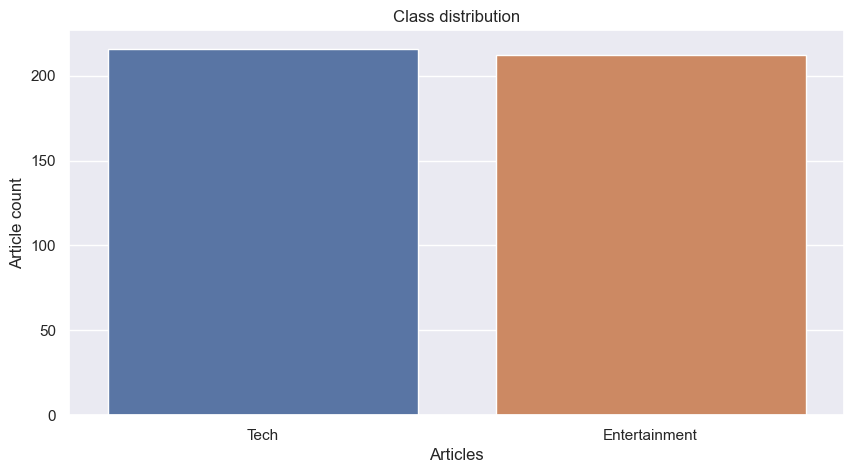

In [4]:
sns.set(rc = {'figure.figsize':(10,5)})
plot = sns.barplot(x=['Tech', 'Entertainment'], y=[train_tech.size, train_entertain.size])
plot.set_xlabel('Articles')
plot.set_ylabel('Article count')
plot.set_title('Class distribution')
plt.show()

In [5]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

# encode document
vector = vectorizer.transform(X_test)
prep_X_test = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_test.index)

vector = vectorizer.transform(X_train)
prep_X_train = pd.DataFrame(vector.toarray(), columns=sorted(vectorizer.vocabulary_), index=X_train.index)
print(prep_X_test.shape)
print(prep_X_train.shape)

(106, 13518)
(428, 13518)


# Task 2(a)

## Naive Bayes

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
import warnings

weight_init_range = [0,0.1]

# New MLP class to override init method to initialize weights
class MLPClassifierOverride(MLPClassifier):
    # Overriding _init_coef method
    def _init_coef(self, fan_in, fan_out, dtype):
        # Initialize weights and biases by uniformly sampling from range [0, 0.1]
        coef_init = np.random.uniform(
            weight_init_range[0], weight_init_range[1], (fan_in, fan_out)
        )
        intercept_init = np.random.uniform(weight_init_range[0], weight_init_range[1], fan_out)
        coef_init = coef_init.astype(dtype, copy=False)
        intercept_init = intercept_init.astype(dtype, copy=False)
        return coef_init, intercept_init

In [7]:
from sklearn.naive_bayes import MultinomialNB
import math

# alpha = 1.0 ==> Laplace Smoothing; not perfectly balanced data ==> fit_prior = TRUE
nb_classifier = MultinomialNB(alpha = 1.0, fit_prior = True)

# Fit data to classifier
nb_classifier.fit(prep_X_train_count, Y_train)

# Get log-likelihood of features given a class, i.e. P(x_i|y)
log_like_class0 = nb_classifier.feature_log_prob_[0]
log_like_class1 = nb_classifier.feature_log_prob_[1]

    preds = clf.predict(prep_X_test)
    
    score = f1_score(Y_test, preds)

    training_losses.append(clf.loss_curve_)
    results.append([hid_unit, score])

print(top20_class0)
print(top20_class1)

# Calculate the values of the ratio between likelihoods for class 0
# P(x_i|y = 0) / P(x_i|y = 1)
ratio_class0 = np.exp(log_like_class0) / np.exp(log_like_class1)

# Calculate the values of the ratio between likelihoods for class 1
# P(x_i|y = 1) / P(x_i|y = 0)
ratio_class1 = np.exp(log_like_class1) / np.exp(log_like_class0)

# Sort indices of ratios, from largest ratio to smallest
# By negation rule, smallest items are originally the largest
max_index_ratio_class0 = np.argsort(-ratio_class0)
max_index_ratio_class1 = np.argsort(-ratio_class1)

# Top-20 words that maximise the quantity
top20_ratio_class0 = np.array(prep_X_train_count.columns)[max_index_ratio_class0][0:20]
top20_ratio_class1 = np.array(prep_X_train_count.columns)[max_index_ratio_class1][0:20]

print(top20_ratio_class0)
print(top20_ratio_class1)


[[5, 0.5111111111111111], [20, 0.6021505376344086], [40, 0.7735849056603773]]


## (i)
The top-20 most identifiable words that are most likely to occur inthe articles over class ```tech``` and ```entertainment``` is:

|Rank|tech| |Rank| entertainment |
|:---:|:---:|---|:---:|:---:|
|1|said||1|said|
|2|people||2|film|
|3|new||3|best|
|4|mobile||4|year|
|5|mr||5|music|
|6|one||6|also|
|7|also||7|us|
|8|would||8|new|
|9|could||9|one|
|10|technology||10|show|
|11|use||11|first|
|12|users||12|awards|
|13|net||13|tv|
|14|software||14|last|
|15|games||15|uk|
|16|us||16|actor|
|17|music||17|number|
|18|many||18|band|
|19|year||19|mr|
|20|phone||20|star|

Note that in the code, we can compare the likelihood on log scale because it is monotonic.

## (ii)
The top-20 words that maximise the following quantity
$\begin{align*}
\frac{\mathbb{P}(X_w = 1|Y = y)}{\mathbb{P}(X_w = 1|Y \neq y)}
\end{align*}$:

|Rank|Y = tech| |Rank|Y = entertainment|
|:---:|:---:|---|:---:|:---:|
|1|users||1|actress|
|2|software||2|singer|
|3|microsoft||3|oscar|
|4|mobile||4|stars|
|5|broadband||5|aviator|
|6|virus||6|band|
|7|firms||7|nominated|
|8|pc||8|rock|
|9|spam||9|festival|
|10|phones||10|album|
|11|gadget||11|nominations|
|12|net||12|charles|
|13|consumer||13|chart|
|14|mobiles||14|foxx|
|15|gadgets||15|oscars|
|16|machines||16|starring|
|17|windows||17|singles|
|18|technologies||18|jamie|
|19|systems||19|swank|
|20|pcs||20|comedy|

The (ii) top-20 words that maximise the quantity is better than the (i) top-20 most identifiable words that are most likely to occur over 2 classes. It is because (i) calculate the corresponding likelihood, but not comparing the likelihood to that of other classes. We do not know whether the word will be more likely to be in class `tech` or `entertainment`. In contrast, (ii) actually calculates the relative likelihood. If the ratio is greater than 1, it means that the word will be more likely to be in the numerator class than that of the denominator class. Therefore, the lists of (ii) will better decribe the class.

# Task 3(a)

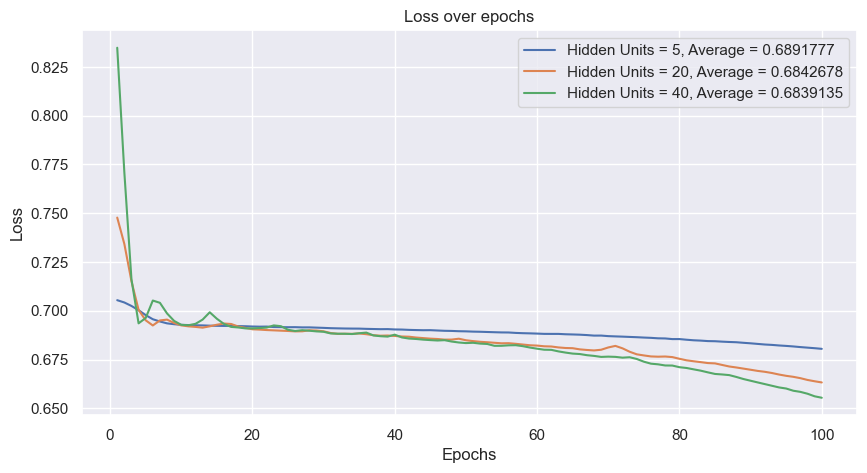

In [8]:
epochs = np.arange(1, 101)
average_losses = np.mean(training_losses, axis=1)
average_losses = np.round(average_losses, decimals= 7)

plot = sns.lineplot(x = epochs, y = training_losses[0], label = str('Hidden Units = 5, Average = ' + str(average_losses[0])))
sns.lineplot(x = epochs, y = training_losses[1], label = str('Hidden Units = 20, Average = ' + str(average_losses[1])))
sns.lineplot(x = epochs, y = training_losses[2], label = str('Hidden Units = 40, Average = ' + str(average_losses[2])))
plot.set_title('Loss over epochs')
plot.set_xlabel('Epochs')
plot.set_ylabel('Loss')
plt.legend()
plt.show()

Given that we're isolating the effects of hidden units on the average loss in training, it looks like theres an inverse relationship between them. As hidden units increase, the average loss decreases. The graph above shows the changes in loss over each epoch of training, and how there's more improvement as we increase hidden units.

In [9]:
splits = [0.1, 0.3, 0.5, 0.7, 0.9]
#splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

np.random.seed(1)

T3_train_scores = []
T3_test_scores = []
train_size = prep_X_train.shape[0]

for i in splits:
    split = int(i*train_size)
    T3_X_train = prep_X_train.iloc[:split]
    T3_y_train = Y_train.iloc[:split]

    T3_clf = MLPClassifier(activation='relu', alpha=0.1, learning_rate_init=0.01, hidden_layer_sizes=(20,20), solver='sgd')
    T3_clf.fit(T3_X_train, T3_y_train)

    train_pred = T3_clf.predict(T3_X_train)
    train_score = f1_score(T3_y_train, train_pred)

    test_pred = T3_clf.predict(prep_X_test)
    test_score = f1_score(Y_test, test_pred)

    T3_train_scores.append(train_score)
    T3_test_scores.append(test_score)
    
print(T3_test_scores)
print(T3_train_scores)

[0.673913043478261, 0.9838709677419354, 0.991869918699187, 0.9917355371900827, 0.9917355371900827]
[1.0, 0.9924812030075187, 1.0, 0.9965156794425087, 0.9974025974025974]


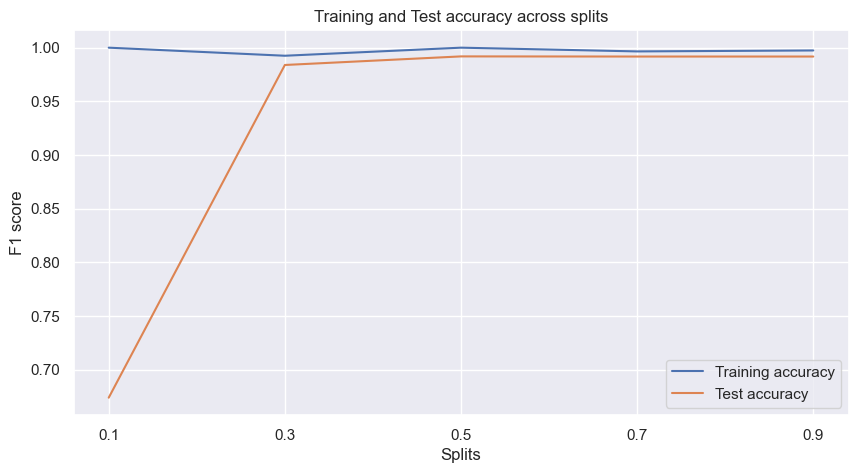

In [10]:
""" fig, ax = plt.subplots(ncols=2, figsize=(25, 15))
ax[0] = sns.lineplot(x=splits, y=T3_train_scores, ax=ax[0])
ax[0].set_title('Training Accuracy across splits')
ax[0].set(xlabel='Splits', ylabel='F1 score')

ax[1] = sns.lineplot(x=splits, y=T3_test_scores, ax=ax[1])
ax[1].set_title('Test Accuracy across splits')
ax[1].set(xlabel='Splits', ylabel='F1 score')
 """

plot = sns.lineplot(x=[str(i) for i in splits], y=T3_train_scores, label = 'Training accuracy')
sns.lineplot(x=[str(i) for i in splits], y=T3_test_scores, label ='Test accuracy')
plot.set_title('Training and Test accuracy across splits')
plot.set(xlabel='Splits', ylabel='F1 score')

plt.show()

For Neural networks, training set size seems to be directly correlated to the f1-score. This makes sense as more training examples gives the model better chances at converging to an optimal minima. The dip in 0.5 might just be a result of chance where some training examples brought the gradient away from the actual minima. 

In [11]:
# Hyper parameters to tune:
# Shape of hidden layers (), Learning rate, weight initialization, l2 regularization alpha, activation
from sklearn.model_selection import GridSearchCV

shape_of_hidden_layers = [(20,), (40,), (10,10), (20,20), (40, 40), (10,10,10), (20,20,20)]
learning_rate = [1,0.1,0.01,0.001,0.0001]
alpha = [0.1,0.01,0.001,0.0001,0.00001]
activation = ['relu','logistic','tanh']

In [12]:
np.random.seed(1)

hid_clf = MLPClassifier(solver='sgd')
hid_cv = GridSearchCV(hid_clf, {'hidden_layer_sizes': shape_of_hidden_layers}, scoring='f1', verbose=10, n_jobs=-1)
hid_cv.fit(prep_X_train,Y_train)

ler_clf = MLPClassifier(solver='sgd')
ler_cv = GridSearchCV(ler_clf, {'learning_rate_init': learning_rate}, scoring='f1', verbose=10, n_jobs=-1)
ler_cv.fit(prep_X_train,Y_train)

alpha_clf = MLPClassifier(solver='sgd')
alpha_cv = GridSearchCV(alpha_clf, {'alpha': alpha}, scoring='f1', verbose=10, n_jobs=-1)
alpha_cv.fit(prep_X_train,Y_train)

activation_clf = MLPClassifier(solver='sgd')
activation_cv = GridSearchCV(activation_clf, {'activation': activation}, scoring='f1', verbose=10, n_jobs=-1)
activation_cv.fit(prep_X_train,Y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:907: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
C:\Users\User\an

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=MLPClassifier(solver='sgd'), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic', 'tanh']},
             scoring='f1', verbose=10)

In [13]:
best_hid = hid_cv.best_params_['hidden_layer_sizes']
best_ler = ler_cv.best_params_['learning_rate_init']
best_alpha = alpha_cv.best_params_['alpha']
best_activation = activation_cv.best_params_['activation']

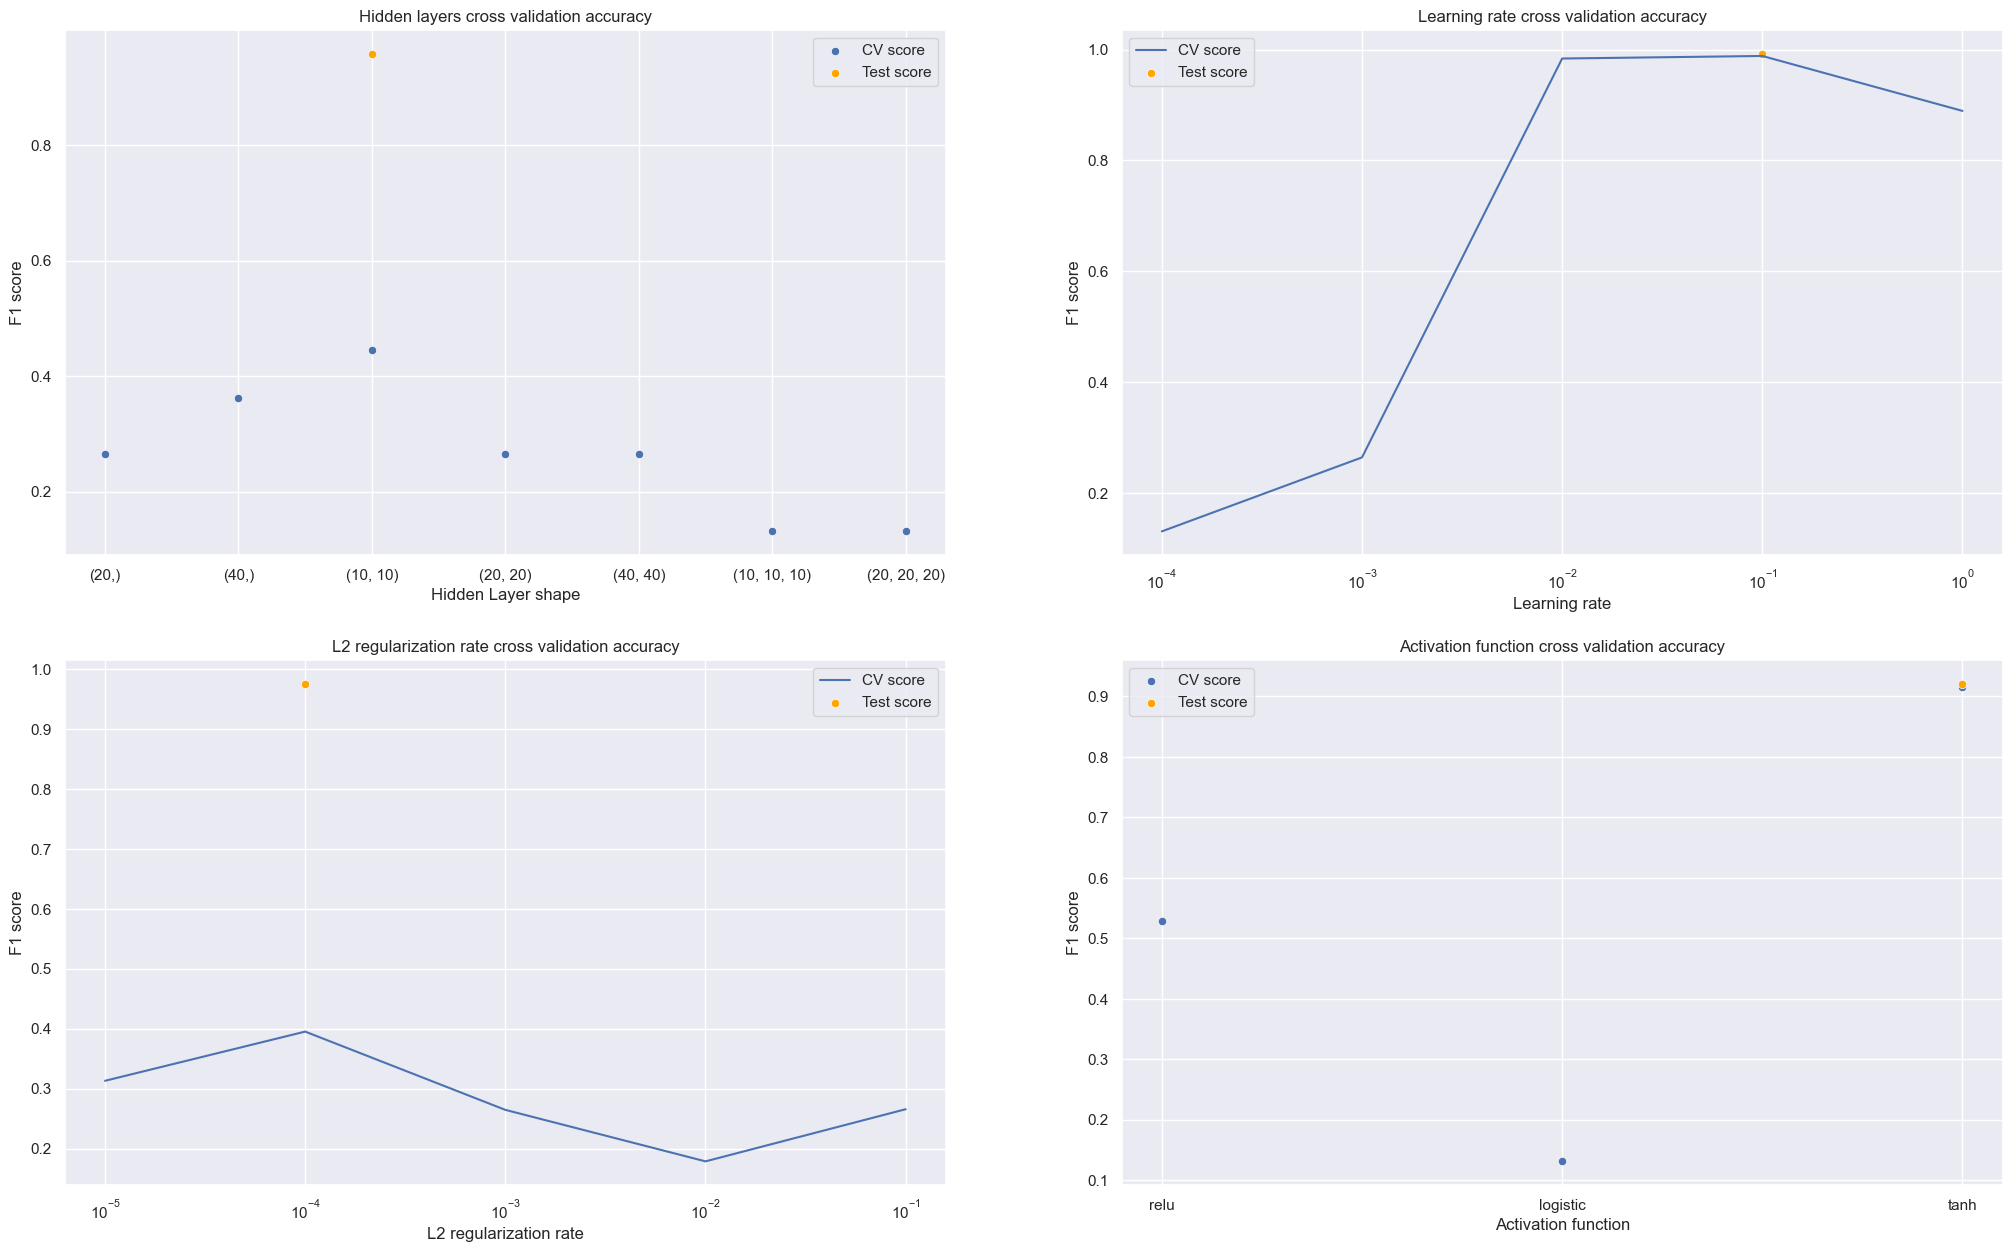

Train set f1-score = 0.4446. Test set f1-score = 0.9573. Hidden layer shape = (10, 10)
Train set f1-score = 0.9883. Test set f1-score = 0.9917. Learning rate = 0.1
Train set f1-score = 0.3952. Test set f1-score = 0.9752. L2 regularization rate = 0.0001
Train set f1-score = 0.9158. Test set f1-score = 0.9204. Activation function = tanh


In [18]:
string_hlayers = [str(i) for i in shape_of_hidden_layers]
hid_pred = hid_cv.predict(prep_X_test)
hid_score = f1_score(Y_test, hid_pred)

ler_pred = ler_cv.predict(prep_X_test)
ler_score = f1_score(Y_test, ler_pred)

alpha_pred = alpha_cv.predict(prep_X_test)
alpha_score = f1_score(Y_test, alpha_pred)

activation_pred = activation_cv.predict(prep_X_test)
activation_score = f1_score(Y_test, activation_pred)

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(25, 15))
ax[0, 0] = sns.scatterplot(x=string_hlayers, y=hid_cv.cv_results_['mean_test_score'], ax=ax[0,0], label='CV score')
ax[0, 0].set_title('Hidden layers cross validation accuracy')
ax[0, 0].set(xlabel='Hidden Layer shape', ylabel='F1 score')
sns.scatterplot(x=[str(best_hid)], y=hid_score, ax=ax[0, 0], color = 'orange', label='Test score')

ax[0, 1] = sns.lineplot(x=learning_rate, y=ler_cv.cv_results_['mean_test_score'], ax=ax[0,1], label='CV score')
ax[0, 1].set(xscale="log")
ax[0, 1].set_title('Learning rate cross validation accuracy')
ax[0, 1].set(xlabel='Learning rate', ylabel='F1 score')
sns.scatterplot(x=[float(best_ler)], y=ler_score, ax=ax[0, 1], color = 'orange', label='Test score')

ax[1, 0] = sns.lineplot(x=alpha, y=alpha_cv.cv_results_['mean_test_score'], ax=ax[1, 0], label='CV score')
ax[1, 0].set(xscale="log")
ax[1, 0].set_title('L2 regularization rate cross validation accuracy')
ax[1, 0].set(xlabel='L2 regularization rate', ylabel='F1 score')
sns.scatterplot(x=[float(best_alpha)], y=alpha_score, ax=ax[1, 0], color = 'orange', label='Test score')

ax[1, 1] = sns.scatterplot(x=activation, y=activation_cv.cv_results_['mean_test_score'], ax=ax[1, 1], label='CV score')
ax[1, 1].set_title('Activation function cross validation accuracy')
ax[1, 1].set(xlabel='Activation function', ylabel='F1 score')
sns.scatterplot(x=[best_activation], y=activation_score, ax=ax[1, 1], color = 'orange', label='Test score')

plt.show()

print('Train set f1-score = %.4f. Test set f1-score = %.4f. Hidden layer shape = %s' %(hid_cv.best_score_, hid_score, best_hid))
print('Train set f1-score = %.4f. Test set f1-score = %.4f. Learning rate = %s' %(ler_cv.best_score_, ler_score, best_ler))
print('Train set f1-score = %.4f. Test set f1-score = %.4f. L2 regularization rate = %s' %(alpha_cv.best_score_, alpha_score, best_alpha))
print('Train set f1-score = %.4f. Test set f1-score = %.4f. Activation function = %s' %(activation_cv.best_score_, activation_score, best_activation))

Using a 5 fold cross validation on our training dataset, we can see trends in the different hyperparameteres we used. Training a neural network requires time and powerful hardware, hence why we just focused on looking into the effects of individual hyperparameters per cross validation step rather than a combination of multiple hyperparameters. We kept all the other hyperparemeters at default. This does have its caveats as we kept max epochs at default = 200. Performance might get affected as some hyperparameters like learning rate and hidden layers might prevent the model from converging at an optimal result before stopping. The plot above shows the mean cv score per each hyper parameter training, as well as the test score for the best hyperparameter.

- Weight initialization is a hyper parameter, and from the results of Task 2d, randomizing the weights isn't an ideal choice. Scikit learn implements the Xavier-Glorot initialization which is a widely used initialization technique that uniformly samples the weights of the current layer depeding on both sizes of the current and previous layers. This has shown better results in all our cross validations.
- Increasing both the number of neurons and hidden layers adds complexity to our model. In the first graph, we can see some underfitting in our training accuracy, but as the layers and number of neurons increase, there's some possibility that it overfits the data. A good cross validation result seems to be two hidden layers with 20 neurons each.
- Learning rate determines the steps the model takes during SGD. Scikit limits the max epochs to 200 and thus smaller learning rates might not even converge at all. There's also a possibility that it might get stuck in a local minima, thus decreasing performance. Larger weights on the other hand might completely miss the minima and underfit the model.
- We've tried exploring the effects of L2 regularization in our model and found that a regularization rate of 0.1 seems to provide us with the best results. This means that the higher the rate, the model gets simpler as to not overfit the data but might cause some bias. 
- Lastly for the activation function, we found that a simple relu activation function proved to be helpful in our classification. The default scikit NN only has a single layer with 100 neurons that connects to the output, and thus it's not prone to any vanishing or exploding gradients. Eitherway, the best option seems to be a ReLU function which paired with our multi-layered choice of hyperparameter, is better at preventing any vanishing/exploding gradients.

0.9917355371900827


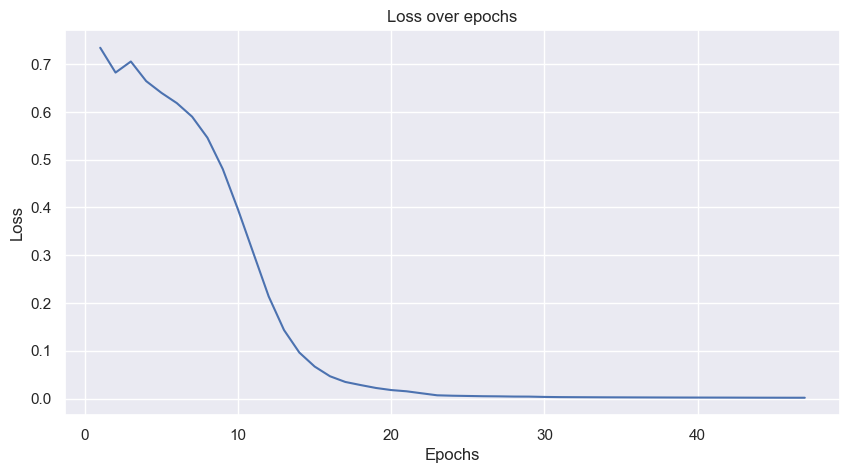

In [16]:
# Using final hyperparameters used in tuning
np.random.seed(1)

final_clf = MLPClassifier(activation='tanh', alpha=0.0001, learning_rate_init=0.1, hidden_layer_sizes=(10,10), solver='sgd')
final_clf.fit(prep_X_train,Y_train)
loss_list = np.array(final_clf.loss_curve_)

pred = final_clf.predict(prep_X_test)
score = f1_score(Y_test, pred)
print(score)

epochs = np.arange(1, len(loss_list)+1)

plot = sns.lineplot(x = epochs, y = loss_list)
plot.set_title('Loss over epochs')
plot.set_xlabel('Epochs')
plot.set_ylabel('Loss')
plt.show()